Output()

/tmp/ipython-input-3711170506.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


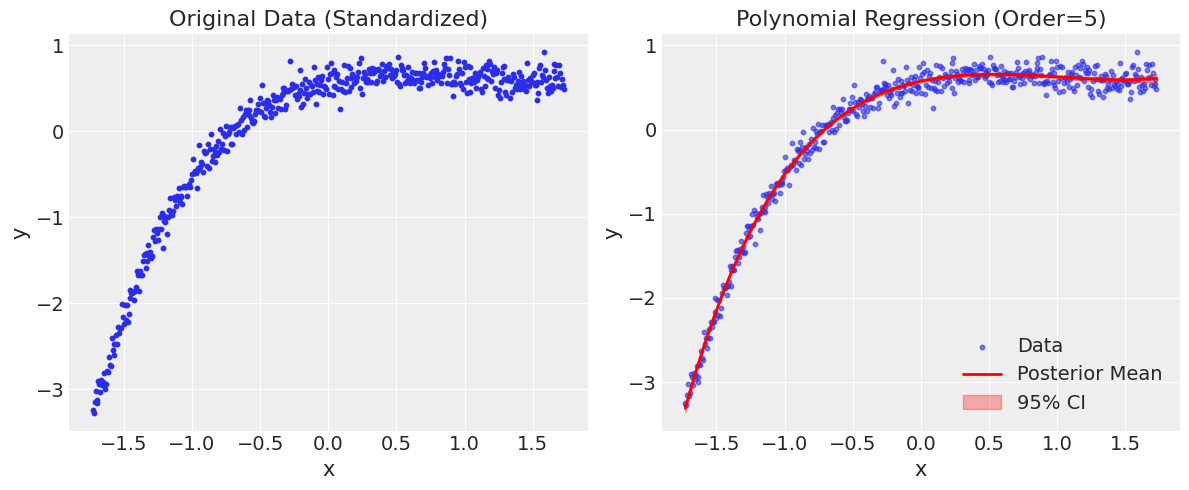

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha    0.000  0.004  -0.008    0.008      0.000    0.000    3486.0   
beta[0]  0.350  0.020   0.312    0.385      0.000    0.000    1698.0   
beta[1] -0.421  0.016  -0.452   -0.392      0.000    0.000    2080.0   
beta[2]  0.422  0.050   0.329    0.516      0.001    0.001    1548.0   
beta[3] -0.140  0.016  -0.169   -0.110      0.000    0.000    2140.0   
beta[4]  0.075  0.035   0.009    0.139      0.001    0.001    1631.0   
epsilon  0.101  0.003   0.095    0.107      0.000    0.000    3007.0   

         ess_tail  r_hat  
alpha      2463.0    1.0  
beta[0]    2216.0    1.0  
beta[1]    2071.0    1.0  
beta[2]    1929.0    1.0  
beta[3]    2107.0    1.0  
beta[4]    2317.0    1.0  
epsilon    2653.0    1.0  


In [4]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
az.style.use('arviz-darkgrid')

# Generate 500 data points
np.random.seed(42)
x_1 = np.linspace(-1.5, 1.5, 500)
y_1 = 0.5 + 2*x_1 - 3*x_1**2 + 1.5*x_1**3 - 0.5*x_1**4 + 0.2*x_1**5 + np.random.normal(0, 0.5, 500)

order = 5

# Create polynomial features
x_1p = np.vstack([x_1**i for i in range(1, order+1)])

# Standardize features
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True)) / x_1p.std(axis=1, keepdims=True)

# Standardize target
y_1s = (y_1 - y_1.mean()) / y_1.std()

# Build the model
with pm.Model() as model_p:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=order)
    epsilon = pm.HalfCauchy('epsilon', beta=5)
    mu = alpha + pm.math.dot(beta, x_1s)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=epsilon, observed=y_1s)
    trace_p = pm.sample(2000, tune=1000, return_inferencedata=True)

# Plot original data
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(x_1s[0], y_1s, s=10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Original Data (Standardized)')

# Inference and plot the curve
plt.subplot(1, 2, 2)
plt.scatter(x_1s[0], y_1s, alpha=0.6, label='Data', s=10)

x_range = np.linspace(x_1s[0].min(), x_1s[0].max(), 100)
x_range_original = x_range * x_1p.std(axis=1, keepdims=True)[0] + x_1p.mean(axis=1, keepdims=True)[0]
x_range_poly = np.vstack([x_range_original**i for i in range(1, order+1)])
x_range_std = (x_range_poly - x_1p.mean(axis=1, keepdims=True)) / x_1p.std(axis=1, keepdims=True)

alpha_post = trace_p.posterior['alpha'].values.flatten()
beta_post = trace_p.posterior['beta'].values.reshape(-1, order)

y_pred_samples = []
for i in range(len(alpha_post)):
    y_pred_i = alpha_post[i] + np.dot(beta_post[i], x_range_std)
    y_pred_samples.append(y_pred_i)
y_pred_samples = np.array(y_pred_samples)

y_pred_mean = y_pred_samples.mean(axis=0)
plt.plot(x_range, y_pred_mean, 'r-', linewidth=2, label='Posterior Mean')
y_pred_lower = np.percentile(y_pred_samples, 2.5, axis=0)
y_pred_upper = np.percentile(y_pred_samples, 97.5, axis=0)
plt.fill_between(x_range, y_pred_lower, y_pred_upper, alpha=0.3, color='red', label='95% CI')

plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Polynomial Regression (Order={order})')
plt.legend()
plt.tight_layout()
plt.show()

print(az.summary(trace_p))